# Regional Voting Preferences in the 2019 Philippine Senatorial Elections


The Philippines recently concluded its 2019 midterm elections last May 13. Sixty-two (62) candidates from various political parties contested for twelve (12) seats in the Senate of The Philippines. Given the unexpected results, the team was wondering on the following topics:

- How did the various administrative regions of the Philippines voted for their senators? 
- Is the voter preference homogeneous across the country, or is there a preferred candidate or party per region? More specifically, how does (1) religious affiliation, (2) educational attainment, and (2) sex play a major role on how the voters select their candidates. 

In [1]:
from IPython.display import HTML

HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

Before anything else, let us first load all important modules for this exercise.

In [2]:
import os
import io
import re
import time
import glob
import requests
import urllib.request
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

It is important to identify the datasets we are going to use for this exercise. The two identified datasets the group intends to use are: the 2019 National Data and the 2015-2016 Census data. 
    
With regards to 2019 National data, the team used a web scapper provided Prof. Alis. The web scapper downloaded the election results from the [Commission of Elections' 2019 National and Local Elections website](https://2019electionresults.comelec.gov.ph/#/dashboard). The results were then stored in a local repository which is then easily accesible for the team. The 2019 elections results are broken down into two main directories: `results` and `contest`. In this exercise, the team will explore both directories to map out a comprehensive summary of the 2019 senatorial and party elections.

Secondly, the 2015-2016 Census data has already been stored in a local repository for easier access. One of the main reasons why the team decided to use the 2015-2016 Census data is because of the lack of availability of recent data. The Philippine Statistics Authority only releases a comprehensive census survey ever six years. However for the purpose of this exercise, the team has agreed that the 2015-2016 census data can act as an appproximate for today's population.

## <font color="BF5209"> A. Methodology

### <font color="BF5209"> Step 1: Extract and collect the 2019 Elections (Results) data

The first directory to explore is the 2019 Election `results`. The `results` directory contains all electoral results from a regional level down to the barangay level. For each level, a specific `coc.json` file is stored. This file contains all electoral results data and metadata for both national and local elections. However for the purposes of this analysis, we will only look at the aggregated elections data at the regional level. The files that we are interested are the `coc.json` files associated to each province, as these files contain the metadata and data on the election results. 

The main structure of each `coc.json` file contains the following main keys: `vbc`, `rs`, `sts`, `obs`, and `cos`. For the purpose of this exercise, the important key the group needs to extract is the `rs` key as this provides the each candidate's total votes per area. Under the `rs` key, the following keys can be found: `cc`, `bo`, `v`, `tot`, `per`, and `ser`. Cross referencing these keys with official statements and comelec documentations suggests that important keys are as follows: `cc` pertaining to `contest_type`, `bo` pertaining to the `candidate_id`, and `v` pertaining to `votes_per_province`. 

| Parameter | Description               |
|-----------|---------------------------|
|   cc      | Contest code              |
|   bo      | Contestant id             |
|   v       | Total votes per contestant|
|   tot     | Total votes per province  |

However, it must be pointed out that the available data only goes as high as provincial data. If we want to process the provincial level, the team will have to aggregate the data up.

The group created utility functions for easier retrieval of the provincial elections datasets. The purpose for the utility functions (and future utility functions) are for initial cleaning and manipulations. This is to ensure each dataset is ready for aggregation. 

The `get_province_coc` method unpacks each key and value from the `coc.json` dictionary into a cleaned up dataframe. In addition, the method identifies which region and province the file originated from by examining the filepath that was passed. 

The `get_all_province_coc` method is a walker that goes through each of the `results` directory. The walker checks if the filename has an equal value to `coc.json`. If a `coc.json` was located, the `get_province_coc` method is applied with the `filepath` as the parameter. The resulting dataframe is then appended to a master dataframe for further extraction and analysis. For this exercise, the group only had to extract data up to the regional and provincial levels so only three wildcard were use for the `glob` walker. 

Special methods (`get_ncr_coc` and `get_all_ncr_coc`) were established to get the cities' `coc.json`. For the case of the NCR cities, theire associated `coc.json` files were one directory lower.

In [3]:
def get_province_coc(filepath):
    """
    Loads a single coc file. 

    Adds additional columns `region` and `province to the DataFrame,
    depending on filepath.

    Parameters
    ----------
    filepath    : filepath

    Return
    ------
    df          : a dataframe
    """
    output = []
    with open(filepath, 'r') as f:
        dirpath, filepath = os.path.split(filepath)
        region = dirpath.split('/')[-2]
        province = dirpath.split('/')[-1]
        data = json.load(f)
        for each in data['rs']:
            row = [float(element) for element in list(each.values())]
            output.append([data['vbc']] + row + [region] + [province])
    df = pd.DataFrame(output,
                      columns=['vbc', 'cc', 'bo', 'v', 'tot', 'per', 'ser',
                               'region', 'province'])
    return df


def get_all_province_coc(tree):
    """
    Loads all province COC files and saves them to a dataframe

    Checks the filepath if filename is 'coc.json'

    Created a new column to deal with the reclassification of
        "NEGROS ORIENTAL" and "NEGROS OCCIDENTAL" to "NIR" 
            to match the PSA 2016 dataset.

    Parameters
    ----------
    filepath    : filepath

    Return
    ------
    df          : a dataframe
    """
    total = pd.DataFrame()
    for file in glob.glob(tree):
        if os.path.basename(file) == 'coc.json':
            df = get_province_coc(file)
            total = total.append(df)
    total.rename(columns={'region': 'region_raw'}, inplace=True)
    total['region'] = total['region_raw'].copy()
    total.loc[(total['province'] == "NEGROS ORIENTAL") |
              (total['province'] == "NEGROS OCCIDENTAL"), 'region'] = 'NIR'
    return total

In [4]:
def get_ncr_coc(filepath):
    """
    Loads a single coc file. 

    Adds additional columns `region` and `province to the DataFrame,
    depending on filepath.

    Parameters
    ----------
    filepath    : filepath

    Return
    ------
    df          : a dataframe    

    """
    output = []
    with open(filepath, 'r') as f:
        dirpath, filepath = os.path.split(filepath)
        region = dirpath.split('/')[-3]
        province = dirpath.split('/')[-2]
        data = json.load(f)
        for each in data['rs']:
            row = [float(element) for element in list(each.values())]
            output.append([data['vbc']] + row + [region] + [province])
    df = pd.DataFrame(output,
                      columns=['vbc', 'cc', 'bo', 'v', 'tot', 'per', 'ser',
                               'region', 'province'])
    return df


def get_all_ncr_coc(tree):
    """
    Loads all province COC files and saves them to a dataframe

    Checks the filepath if filename is 'coc.json'

    Parameters
    ----------
    filepath    : filepath

    Return
    ------
    df          : a dataframe
    """
    total = pd.DataFrame()
    for file in glob.glob(tree):
        if file.split('/')[7] == 'NCR':
            if os.path.basename(file) == 'coc.json':
                df = get_ncr_coc(file)
                total = total.append(df)
    total.rename(columns={'region': 'region_raw'}, inplace=True)
    total['region'] = total['region_raw'].copy()
    return total

###  With these utility functions inplace, the team can now apply these methods for easier access to the 2019 elections data. 

We can now compile all of the election results with the following line:

In [5]:
tree = '/mnt/data/public/elections/nle2019/results/*/*/*'
ncr_tree = '/mnt/data/public/elections/nle2019/results/*/*/*/*'
df_results = get_all_province_coc(tree)
df_results = df_results.append(get_all_ncr_coc(ncr_tree))
df_results.drop_duplicates(inplace=True)

In [6]:
df_results.head(5)

,vbc,cc,bo,v,tot,per,ser,region_raw,province,region
0,89550,1.0,1.0,2004.0,1708769.0,0.11,2800.0,REGION I,ILOCOS NORTE,REGION I
1,89550,1.0,2.0,1607.0,1708769.0,0.09,2800.0,REGION I,ILOCOS NORTE,REGION I
2,89550,1.0,3.0,8772.0,1708769.0,0.51,2800.0,REGION I,ILOCOS NORTE,REGION I
3,89550,1.0,4.0,1767.0,1708769.0,0.10,2800.0,REGION I,ILOCOS NORTE,REGION I
4,89550,1.0,5.0,5068.0,1708769.0,0.29,2800.0,REGION I,ILOCOS NORTE,REGION I


### Next, let us examine the obtained dataset with actual election results. 

By cross checking the results with [Comelec data](https://www.comelec.gov.ph/?r=2019NLE/ListsOfCandidates/CertifiedListofCandidates), we can identify the senators and party names.

Just to check our data, we can look at an example senator from the dataset. By choosing `cc=1` and `bo=46`, we are actually highlighting Imee Marcos' senatorial candidacy results.

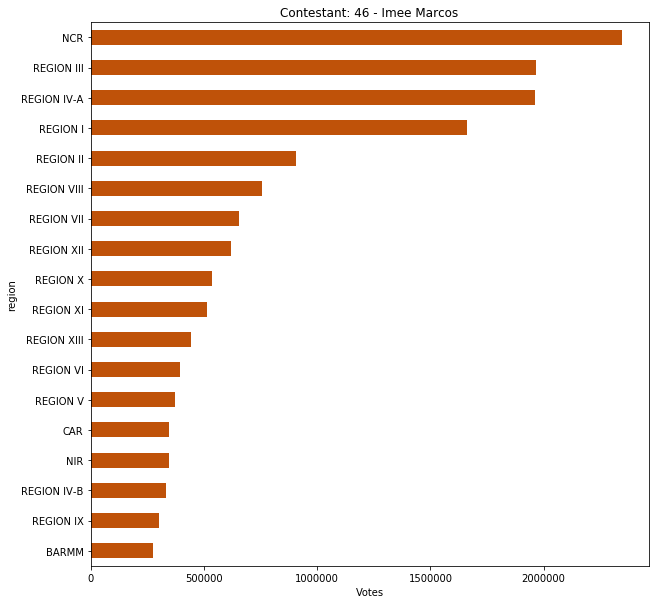

In [7]:
fig, ax = plt.subplots()
ax.set_xlabel('Votes')
df_marcos = df_results.query('cc == 1 & bo == 46').copy()
df_marcos.groupby('region').sum()['v'].sort_values(
    ascending=True).plot.barh(figsize=(10, 10),
                              title='Contestant: 46 - Imee Marcos',
                              color='#BF5209', ax=ax);

Additionally, let us check some descriptive statistics for the 2019 Elections dataset. More specifically, let us examine the `v` or `votes` column. The group will be highly dependent on the `votes` data so let us first do some initial statistics and visualizations.

In [8]:
df_test = df_results.groupby(['region', 'province'])['v'].sum().to_frame()
df_test = df_test.rename(columns={'v': 'votes'})
df_test

votes
region      province                                             
BARMM       BASILAN                                     2093067.0
            LANAO DEL SUR                               4770462.0
            MAGUINDANAO                                 5917983.0
            SULU                                        3529555.0
            TAWI-TAWI                                   1874486.0
CAR         ABRA                                        1923481.0
            APAYAO                                       703002.0
            BENGUET                                     2426397.0
            IFUGAO                                      1408688.0
            KALINGA                                     1621414.0
            MOUNTAIN PROVINCE                           1074249.0
NCR         NATIONAL CAPITAL REGION - FOURTH DISTRICT  22896771.0
            NATIONAL CAPITAL REGION - MANILA           13461229.0
            NATIONAL CAPITAL REGION - SECOND DISTRICT  29803007.0
            NATIONAL CAPITAL REGION - THIRD DISTRICT   18481014.0
            TAGUIG - PATEROS                           10018306.0
NIR         NEGROS OCCIDENTAL                          12453486.0
            NEGROS ORIENTAL                             6900077.0
REGION I    ILOCOS NORTE                                3614806.0
            ILOCOS SUR                                  4882048.0
            LA UNION                                    5764844.0
            PANGASINAN                                 19803192.0
REGION II   BATANES                                      118412.0
            CAGAYAN                                     6890994.0
            ISABELA                                     9632919.0
            NUEVA VIZCAYA                               3200395.0
            QUIRINO                                     1198929.0
REGION III  AURORA                                      1493909.0
            BATAAN                                      6433641.0
            BULACAN                                    19567555.0
...                                                           ...
REGION VI   GUIMARAS                                    1217864.0
            ILOILO                                     11118379.0
REGION VII  BOHOL                                       8977777.0
            CEBU                                       19919139.0
            SIQUIJOR                                     694813.0
REGION VIII BILIRAN                                     1051266.0
            EASTERN SAMAR                               3370187.0
            LEYTE                                       9366390.0
            NORTHERN SAMAR                              3733282.0
            SAMAR (WESTERN SAMAR)                       5954800.0
            SOUTHERN LEYTE                              2558108.0
REGION X    BUKIDNON                                    7415656.0
            CAMIGUIN                                     768370.0
            LANAO DEL NORTE                             3584638.0
            MISAMIS OCCIDENTAL                          4391884.0
            MISAMIS ORIENTAL                            6488743.0
REGION XI   COMPOSTELA VALLEY                           4281424.0
            DAVAO (DAVAO DEL NORTE)                     7056455.0
            DAVAO DEL SUR                               4457484.0
            DAVAO OCCIDENTAL                            1378314.0
            DAVAO ORIENTAL                              3200605.0
REGION XII  COTABATO (NORTH COT.)                       7659458.0
            SARANGANI                                   2990485.0
            SOUTH COTABATO                              9090438.0
            SULTAN KUDARAT                              4037874.0
REGION XIII AGUSAN DEL NORTE                            4670054.0
            AGUSAN DEL SUR                              4155305.0
            DINAGAT ISLANDS                              735236.0
            SURIGAO DEL NORTE     

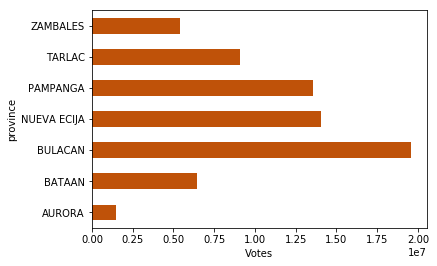

In [9]:
fig, ax = plt.subplots()
ax.set_xlabel('Votes')
df_test.loc['REGION III',"votes"].plot.barh(color='#BF5209', ax=ax);

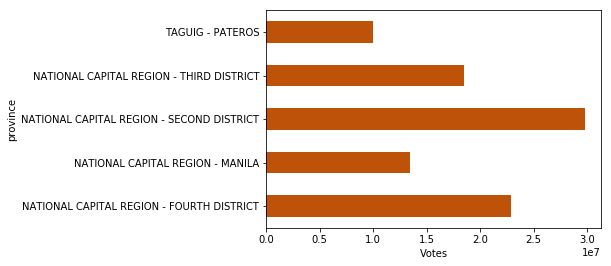

In [10]:
fig, ax = plt.subplots()
ax.set_xlabel('Votes')
df_test.loc['NCR',"votes"].plot.barh(color='#BF5209', ax=ax);

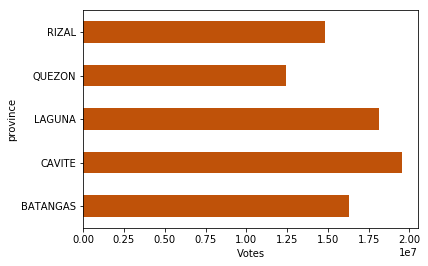

In [11]:
fig, ax = plt.subplots()
ax.set_xlabel('Votes')
df_test.loc['REGION IV-A',"votes"].plot.barh(color='#BF5209', ax=ax);

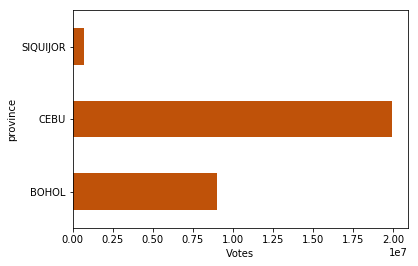

In [12]:
fig, ax = plt.subplots()
ax.set_xlabel('Votes')
df_test.loc['REGION VII',"votes"].plot.barh(color='#BF5209', ax=ax);


To match the contestant ID to the contestant name, the `contest` files were also downloaded from the [Commission of Elections' 2019 National and Local Elections website](https://2019electionresults.comelec.gov.ph/#/dashboard) and stored in the local repository. Similar to the `results` directory, the `contest` directory contained json files for each contest type/position. Upon inspection of a sample file within the directory, the following values were obtained:


The pertinent keys from each json files were:
   
| Parameter | Description               |
|-----------|---------------------------|
|   cc      | Contest code              |
|   cn      | Contest code name - location |
|   ccc     | Contest code name         |
|   type    | Contest type              |
|   bos     | list of candidate parameters|

Under the `bos` key, we can extract each of the candidates' parameters. The more useful ones for the group's study include:

| Parameter | Description               |
|-----------|---------------------------|
|   boc     | Contestant ID             |
|   bon     | Contestant Name           |
|   pn      | Party Name                |

</font>

### <font color="BF5209"> Step 2: Extract and collect the 2019 Elections (Contestant) data

The group also created utility functions for easier retrieval of the contestant datasets. This is to ensure each dataset is ready for aggregation. 

Similar to the `get_province_coc`, the `get_contestant_attrib` method unpacks each key and value from the `{contest_number}.json` dictionary into a cleaned up dataframe. The method converts the `bos` directory into an additional list, which will also be appended into the resulting dataframe. 

There are two (2) major political coalitions fighting for the senate seats:</font>
* **<font color = 'red'>Hugpong ng Pagbabago (HNP)</font>**
* **<span style="background-color: #FFFF00">Otso Diretso</span>**

Similar to the `get_all_province_coc`, the `get_contestants_attrib` method is a walker that goes through each of the `contest` directory. The method will first append all `{contest_numer}.json` files into a singular dataframe. Next, the method creates a new column that identifies who among the senatorial candidates are part of the **Hugpong ng Pagbabago (HNP)** or **Otso Diretso campaign**.

In [13]:
def get_contestant_attrib(filepath):
    """
    Returns the contestant json file into a dataframe

    Parameters
    ----------
    filepath   : string

    Returns
    ----------
    df         : pd.DataFrame of contestnat attributes

    """

    contestants_values = []
    with open(filepath, 'r') as file:
        data = json.load(file)
        attrib_keys = [key for key in list(data.keys())
                       if isinstance(key, (str, float, int))]
        attrib_values = [value for value in list(data.values())
                         if isinstance(value, (str, float, int))]
        contest_values = [list(contest.values()) for contest in data['bos']]
        df = pd.DataFrame(contest_values,
                          columns=list(data['bos'][0].keys()))
        for k, v in zip(attrib_keys, attrib_values):
            df[k] = v
    return df


def get_contestants_attrib(filepath):
    """
    Returns ALL contestant json files into a dataframe

    Parameters
    ----------
    filepath   : string

    Returns
    ----------
    df         : pd.DataFrame of contestant attributes

    """
    df = pd.DataFrame()
    for each_filepath in glob.glob(filepath):
        df = df.append(get_contestant_attrib(each_filepath))
    senators = df[df.cc == 1].copy()
    senators['bon'] = senators['bon'].str.extract(pat='(.*?) \(')
    party = df[df.cc == 5567].copy()
    df = senators.append(party)
    df.drop_duplicates(inplace=True)
    df.rename(columns={'boc': 'bo'}, inplace=True)
    otso = ['AQUINO, BENIGNO BAM ', 'DIOKNO, CHEL', 'HILBAY, PILO',
            'MACALINTAL, MACAROMY', 'GUTOC, SAMIRA', 'ALEJANO, GARY',
            'ROXAS, MAR', 'TAÑADA,LORENZO ERIN TAPAT']
    hnp = ['ANGARA, EDGARDO SONNY', 'BONG REVILLA, RAMON JR', 'CAYETANO, PIA',
           'DELA ROSA, BATO', 'EJERCITO, ESTRADA JV', 'ESTRADA, JINGGOY',
           'GO, BONG GO', 'MANGUDADATU, DONG', 'MANICAD, JIGGY',
           'MARCOS, IMEE', 'PIMENTEL, KOKO', 'TOLENTINO, FRANCIS', 
           'VILLAR, CYNTHIA']
    for o in otso:
        df.loc[df.bon == o, 'coalition'] = "Otso Diretso"
    for h in hnp:
        df.loc[df.bon == h, 'coalition'] = "HNP"
    df['coalition'] = df['coalition'].fillna('None')
    return df

Let us run the `get_contestants_attrib`. This will be used later in the blog for our further analysis.

In [ ]:
contestant_filepaths = '/mnt/data/public/elections/nle2019/contests/*'
df_contestants = get_contestants_attrib(contestant_filepaths)
df_contestants.head()

We now have two dataframes: `df_results` containing the 2019 election results, and `df_contestants` containing the contestant information. These two dataframes can now be merged into a single dataframe. Let us also drop certain columns which we have deemed as unimportant.

In [ ]:
def merge_comelec(results, contestants):
    """
    Merge results dataframe with contestants dataframe

    Parameters
    ----------
    results    : pd.DataFrame
    contestants: pd.DataFrame


    Returns
    ----------
    df         : pd.DataFrame of contestant attributes

    """

    df = pd.merge(results, contestants, on=['bo', 'cc'], how='left')
    df = df.drop(['vbc', 'boi', 'to', 'pc', 'pcc', 'pcy', 'pcm',
                  'pck', 'ccc', 'pre', 'ser', 'cn'], axis=1)
    df.columns = ['position', 'candidate_id', 'votes_per_province',
                  'total_votes', 'votes_in_pct', 'region_raw', 'province',
                  'region', 'candidate_name', 'party_name',
                  'contest_position', 'contest_type', 'coalition']
    return df

In [ ]:
nle2019 = merge_comelec(df_results, df_contestants)
nle2019.region.unique()

### <font color="BF5209"> Step 3: Load `Geopandas` for geospatial processing </font>

The Philippines is composed of **seventeen (17) administrative regions**. We can use the `geopandas` module to manage and pre-process geospatial data.

Let us first load up a geopandas graph of the Philippines.

In [ ]:
fig, ax = plt.subplots(1, figsize=(10, 15), frameon=True)

ph0 = gpd.GeoDataFrame.from_file("ph_regions.shp")
ph0.plot(ax=ax, cmap='Greens', edgecolor='#555555', k=18)
ax.set_title('Regions of the Philippines')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

for ind, row in ph0.iterrows():
    ax.text(row["geometry"].centroid.x, row["geometry"].centroid.y,
            row["region"])

## <font color="BF5209"> B. National Senatorial Results</font>

### Let us look at the senatorial candidates. Let us total up the votes by candidate and see the top 12 winners.

In [ ]:
df_senators = nle2019[nle2019['contest_position'] == 'SENATOR']
df_senator = df_senators.groupby(['candidate_name']).agg(
    {'votes_per_province': sum}).reset_index()
df_senator.sort_values('votes_per_province', ascending=False, inplace=True)
df_senator.columns = ['Candidate', 'Votes']
df_senator.head(12)

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
plt.rcParams.update({'font.size': 14})
df_senator.set_index('Candidate').head(12).sort_values(
    by='Votes', ascending=True).plot.barh(ax=ax,
    title='Top 12 Candidates, in Millions', color='#BF5209', legend=False);
ax.set_xlabel('Total Votes');

## <font color="BF5209"> C. Top Senator Per Region


We want to find out won across all the regions. If there is any bias for cetain candidates.
Based on our findings, we can see that candidate Cynthia Villar won majority of the regions. 

It is interesting to note that the top ranking senator for Ilocos Region (Region I) and the Cordillera Administrative Region (CAR) is **Imee Marcos**, which hails from that region. This confirms that there is a "Solid North", and that support for the Marcoses still exists in that area.

For the Mindanao regions, the top candidate is **Bong Go**, former special assistant to President Duterte, who is from Mindanao.

These show that Philippine politics is **very regional in nature**. Voters will naturally support their hometown candidate, regardless of the issues surrounding that candidate. 


In [ ]:
df_senator_region = df_senators.groupby(
    ['region', 'candidate_name']).agg({'votes_per_province': sum})
df_senator_region['rank'] = df_senator_region.groupby(
    'region')['votes_per_province'].rank('dense', ascending=False)
df_senator_region = df_senator_region[df_senator_region['rank'] == 1].reset_index()
df_senator_region.columns = ['Region', 'Candidate Name', 'Votes', 'Rank']
df_senator_region

In [ ]:
(df_senator_region[df_senator_region['Rank'] == 1].reset_index().groupby(
    'Candidate Name')['Rank'].sum().to_frame().sort_values(by='Rank')
 .reset_index())

In [ ]:
fig, ax = plt.subplots()
(df_senator_region[df_senator_region['Rank'] == 1].reset_index().groupby(
    'Candidate Name')['Rank'].sum().to_frame().sort_values(by='Rank').plot
 .barh(color='#BF5209', ax=ax));
ax.set_xlabel('Rank');


## <font color="BF5209"> D. Dominant Party per Region

There are three main political parties vying for the senatorial seats:
1. **<span style="background-color: #FFFF00">LIBERAL PARTY</span>**
2. **<font color='green'>NACIONALISTA PARTY</font>**
3. **<font color='red'>PARTIDO DEMOKRATIKO PILIPINO LAKAS NG BAYAN (PDP-LABAN)</font>**

We looked at the <font color="BF5209">dominant or majority political party</font> per administrative region, and identify if any regions have any affiliations to a certain party.

In [ ]:
df_party = df_senators.groupby(['region_raw', 'party_name']).agg({
    'votes_per_province': sum})
df_party['rank'] = df_party.groupby(
    'region_raw')['votes_per_province'].rank('dense', ascending=False)
df_party.reset_index(inplace=True)
df_leading_party = df_party[df_party['rank'] == 1].copy()
df_leading_party.columns = ['Region', 'Party', 'Votes', 'Rank']
df_leading_party.sort_values(['Region', 'Rank'], inplace=True)
df_leading_party

We can clearly see a voting bias of each region.

Majority of Region 1 and Region 2 has a voting preference towards the **<font color='green'>NACIONALISTA PARTY</font>**. This can be attributed to the fact that Imee Marcos, who hails from Ilocos Norte, is a Nacionalista.

Majority of Region 5 and Region 6 has a voting preference towards the **<span style="background-color: #FFFF00">LIBERAL PARTY</span>**. This is also expected since Leni Robredo, incumbent Vice President who is from the Liberal Party, is a Bicolano. 

The remainder of the Philippines has a voting preference towards the **<font color='red'>PDP-LABAN</font>**.

In [ ]:
merged = ph0.merge(df_leading_party, left_on='region', right_on='Region')
colors = 18
color_map = {'PARTIDO DEMOKRATIKO PILIPINO LAKAS NG BAYAN': 'red', 
             'LIBERAL PARTY': 'yellow',
             'NACIONALISTA PARTY': 'green'}

fig, ax = plt.subplots(1, 1, figsize = (10,12));
ax.set_title('Dominant political party per region', fontsize=20);

for party in list(merged['Party'].unique()):
    color_map[party]
    merged[merged['Party'] == party].plot(ax=ax, color = color_map[party], 
                                          categorical = True, 
                                          figsize=(10,12), legend=True)

merged.geometry.boundary.plot(color=None,edgecolor='k',linewidth = .5,ax=ax);
plt.rcParams.update({'font.size': 18})

## <font color="BF5209"> E. Dominant Coalition Per Region

Aside from individual candidates and parties, we also looked at the **dominant coalition per region** by counting the number of senate seats obtained by each coalition. The results indicate that HNP gained a majority of the seats across all regions, especially in Mindanao. 

The only regions where HNP did not gain a solid majority are in Bicol Region (Region V) and Eastern Visayas (Region VI), known bailwicks of the Liberal Party.

In [ ]:
def get_coalition_seats():
    """
    Returns a dataframe of the number of seats won per coalition per region

    Returns
    -------
    coalition : pd.DataFrame

    """
    coalition_seats = nle2019.query('position == 1')

    coalition_seats = coalition_seats.groupby(
        ['region', 'candidate_name', 'coalition'],
        as_index=False).agg({'votes_per_province': sum})
    coalition_seats = coalition_seats.sort_values(
        by=['region', 'votes_per_province'], ascending=[1, 0])
    coalition_seats.set_index('region', inplace=True)

    coalition_seats['rank'] = list(range(1, len(
        coalition_seats.candidate_name.unique())+1))\
        * len(coalition_seats.index.unique())
    coalition_seats['is_top_12'] = 1*(coalition_seats['rank'] <= 12)
    coalition_seats = coalition_seats.reset_index()
    coalition_seats = pd.pivot_table(
        coalition_seats, index='region', columns='coalition',
        values='is_top_12', aggfunc=np.sum)
    coalition_seats['coalition_seats_total'] = coalition_seats.sum(axis=1)

    for coalition in coalition_seats.columns[:-1]:
        coalition_seats['party_seats_pct_' + coalition] = \
            coalition_seats[coalition] / \
            coalition_seats['coalition_seats_total']
        coalition_seats.rename(
            columns={coalition: 'coalition_seats_count_' + coalition},
            inplace=True)

    coalition_seats = coalition_seats.round(5)
    coalition_seats = coalition_seats.reset_index()
    return coalition_seats


coalition = get_coalition_seats()
merged = ph0.merge(coalition[[
                   'region', 'coalition_seats_count_HNP']], left_on='region',
                   right_on='region')

fig, ax = plt.subplots(1, 1, figsize=(10, 15))
merged.plot('coalition_seats_count_HNP', ax=ax, cmap='YlOrRd', legend=True)
ax.set_title('Number of HNP senate seats won', fontsize=24)
merged.geometry.boundary.plot(color=None, edgecolor='k', linewidth=1, ax=ax)

## <font color="BF5209"> F. Is Demographics Related To Voting Preference?

Is the voting preference of a region related to its demographics such as literacy rate and religious affiliation? To answer this, we obtained the `2015 Census Data`. The directory is a collection of excel files, where each excel file corresponds to a certain region and province. If we explore each file, we can see that each sheet corresponds to a different demographic feature table. For this analysis, we are intrested at sheets `T8` and `T11`.

The `get_census_religion` loads the imporant columns and rows from sheet `T8`. It also adds an additional column based on the region. Similarly, the `get_census_education` loads the imporant columns and rows from sheet `T11`. It also aggregates each individual years experience column into a singular cumulative column.

Finally, the `read_census_files` aggregates the 2016 regional data into singular dataframe by using `get_census_religion` and `get_census_education` functions. To extract only the regional files, the `read_census_files` uses regex to get filenames with only underscores in the beginning (this is an indicator of regional data).

In [ ]:
def get_census_religion(path):
    """
    Returns a consolidated DataFrame of census data by religion

    Parameters
    ----------
    path      : string, filepath to census directory


    Returns
    ----------
    df        : pd.DataFrame

    """
    filename = os.path.basename(path)
    df = pd.read_excel(path, sheet_name='T8', header=None,
                       usecols=[0, 1, 2, 3],
                       skiprows=6, skip_blank_lines=True,
                       skipfooter=3,
                       names=['religion', 'total', 'm', 'f'])
    df.sort_values('total', ascending=False, inplace=True)
    df['region'] = re.search(r'\_(.*?)\_', os.path.basename(path)).group(1)
    cols = ['region', 'religion', 'm', 'f', 'total']
    df = df[cols]
    return df


def get_census_education(path):
    """
    Returns a consolidated DataFrame of census data by education

    Parameters
    ----------
    path      : string, filepath to census directory


    Returns
    ----------
    df        : pd.DataFrame

    """
    filename = os.path.basename(path)
    df = pd.read_excel(path, sheet_name='T11',
                       usecols=[0, 15, 16, 17, 18, 19, 20],
                       skiprows=3,
                       skip_blank_lines=True, nrows=20,
                       names=['education', '18', '19',
                              '20_24', '25_29', '30_34', '35_above'])
    df.dropna(how='any', inplace=True)
    df.reset_index(inplace=True, drop=True)
    df.drop(df.index[[0, 5, 6, 7, 9, 10, 12, 13]], inplace=True)
    df['total'] = (df['18'] + df['19'] + df['20_24'] + df['25_29'] +
                   df['30_34'] + df['35_above'])
    df['region'] = re.search(r'\_(.*?)\_', os.path.basename(path)).group(1)
    cols = ['region', 'education', '18', '19', '20_24', '25_29', '30_34',
            '35_above', 'total']
    df = df[cols]
    return df


def read_census_files(path):
    '''
    Reads all census regional files

    Parameter
    ---------
    path      : string, filepath to census directory

    Returns
    -------
    Dictionary of dataframes
    '''
    total = {'religion': pd.DataFrame(),
             'education': pd.DataFrame()}

    for filepath in glob.glob(path + ".xls", recursive=True):
        if re.match('_(?!PHILIPPINES)', os.path.basename(filepath)):
            total['religion'] = (total['religion']
                                 .append(get_census_religion(filepath)))
            total['education'] = (total['education']
                                  .append(get_census_education(filepath)))
    total['religion'].reset_index(inplace=True, drop=True)
    total['education'].reset_index(inplace=True, drop=True)

    for df in total.values():
        df.loc[(df['region'] == "ARMM"), 'region'] = 'BARMM'
        df.loc[(df['region'] == "MIMAROPA"), 'region'] = 'REGION IV-B'
        df.loc[(df['region'] == "CARAGA"), 'region'] = 'REGION XIII'
    return total

In [ ]:
census_path = '/mnt/data/public/census/*'
census_dict = read_census_files(census_path)

## <font color="BF5209"> G. Is literacy rate related to voting preference? 

We looked at the number of seats obtained by each coalition per region, then correlated it to literacy rate. Education information was obtained from the 2015 Census data.

We looked at the literacy rate $\frac{n_{educated}}{n_{total}}$ of each administrative region:

In [ ]:
def get_education_percent():
    '''
    Gets percentage of educational level per region
    '''
    education = census_dict['education'].groupby(
        ['region', 'education'], as_index=False).sum()
    education = pd.pivot_table(
        education, index='region', columns='education', values='total')
    education.columns = ['education_pct_' + educ for educ in education.columns]
    education['education_total'] = education.sum(axis=1)
    for educ in education.columns[:-1]:
        education[educ] /= education['education_total']
    education.drop('education_total', axis=1, inplace=True)
    education = education.round(5)

    return education


def get_agg_education_percent():
    '''
    Gets aggregated percentage of educational level per region
    '''
    df_educ = get_education_percent()
    df_educ = df_educ.reset_index()
    df_educ['educated'] = (1 - df_educ['education_pct_No Grade Completed']
                           - df_educ['education_pct_Not Stated'])
    df_educ['not_educated'] = df_educ['education_pct_No Grade Completed']
    df_educ['unknown'] = df_educ['education_pct_Not Stated']
    df_educ.drop(columns=['education_pct_Academic Degree Holder',
                          'education_pct_College Undergraduate',
                          'education_pct_Elementary',
                          'education_pct_High School',
                          'education_pct_No Grade Completed',
                          'education_pct_Not Stated',
                          'education_pct_Post Baccalaureate',
                          'education_pct_Post-Secondary',
                          'education_pct_Pre-School',
                          'education_pct_Special Education'], inplace=True)
    df_educ.set_index('region', inplace=True)
    df_educ.reset_index(inplace=True)
    return df_educ


df_educ = get_agg_education_percent()
df_educ

We then checked if the number of seats obtained by each coalition is correlated to the literacy rate of that region. First, we obtained the number of seats obtained by each coalition per region:

In [ ]:
def get_coalition_rank():
    """
    Get number of seats obtained by each coalition
    """
    coalition_seats = nle2019.query('position == 1')
    coalition_seats = coalition_seats.groupby(
        ['region', 'candidate_name', 'coalition'], as_index=False).agg({'votes_per_province': sum})
    coalition_seats = coalition_seats.sort_values(
        by=['region', 'votes_per_province'], ascending=[1, 0])
    coalition_seats.set_index('region', inplace=True)

    coalition_seats['rank'] = list(range(1, len(
        coalition_seats.candidate_name.unique())+1)) * len(coalition_seats.index.unique())
    coalition_seats['is_top_12'] = 1*(coalition_seats['rank'] <= 12)
    coalition_seats.reset_index(inplace=True)

    coalition_seats = pd.pivot_table(
        coalition_seats, index='region', columns='coalition', values='is_top_12', aggfunc=np.sum)
    return coalition_seats

We then merge this with the education dataframe, then get the correlation:

In [ ]:
df_coal_educ = get_agg_education_percent().set_index('region').join(get_coalition_rank())
df_coal_educ['Educated'] = df_coal_educ['educated']
df_coal_educ['Not Educated'] = df_coal_educ['not_educated']
corr = df_coal_educ.corr().loc[['Otso Diretso', 'HNP'],['Educated', 'Not Educated']]
colormap = sns.diverging_palette(100, 100, n = 10)
sns.heatmap(corr, cmap=colormap, annot=True, vmin = -1, vmax = 1);

The Census and election data show that the voting preference of a region has **no correlation** with its literacy rate. We now look at religion to see if it has a correlation with the voting preference.

##  <font color="BF5209"> H. Is religion related to voting preference? 

We also looked into the religious affiliation per region, and checked if it is correlatd with voting preference.

First, we obtained the distribution of religions per region from the Census data:

In [ ]:
def get_religion_percent():
    """
    Get percentages of religion per region
    """
    religion = census_dict['religion'].groupby(
        ['region', 'religion'], as_index=False).sum()
    religion = pd.pivot_table(
        religion, index='region', columns='religion', values='total')
    religion.columns = ['religion_pct_' + rel for rel in religion.columns]
    religion['religion_total'] = religion.sum(axis=1)
    for rel in religion.columns[:-1]:
        religion[rel] /= religion['religion_total']
    religion.drop('religion_total', axis=1, inplace=True)
    religion = religion.round(5)
    return religion


df_rel = get_religion_percent()

We then merged the religion census data with the coalition ranking data to check if religion has correlation with the number of seats obtained by each coalition:

In [ ]:
df_coal_rel = get_religion_percent().join(get_coalition_rank())
df_coal_rel.head()

From getting the correlation of the religion data with the number of seats per coalition, it is apparent that the Voting preference of a region has **<font color="BF5209">no correlation with its religious affiliation</font>**.

In [ ]:
df_coal_rel['Roman Catholic'] = df_coal_rel['religion_pct_Roman Catholic, including Catholic Charismatic']
df_coal_rel['Islam'] = df_coal_rel['religion_pct_Islam']
df_coal_rel['Iglesia ni Cristo'] = df_coal_rel['religion_pct_Iglesia ni Cristo']
corr = df_coal_rel.corr().loc[
    ['Roman Catholic','Islam','Iglesia ni Cristo'],['HNP','Otso Diretso']]
colormap = sns.diverging_palette(100, 100, n = 10)
sns.heatmap(corr, cmap=colormap, annot=True, vmin = -1, vmax = 1);

## <font color="BF5209"> I. Conclusion

Upon checking both the Comelec 2019 Election Results and the 2015 Philippine Census data, we found out that voting preference is characterized by high regionality. Candidates have a homecourt advantage, and voters tend to vote candidates or parties affiliated with their home region.

Also, literacy rate and religious affiliation is not correlated to voting preference.

## Acknowledgements
We would like to thank Prof Christian Alis and the ACCeSS Laboratory for the access to the high-performance computing facility.